# 머신러닝을 이용한 번역서비스의 언어감지
---


## 1.연구목표 설정

- 유사서비스 : 카카오번역, 파파고, 구글번역..
- 언어 감지 하는 방법은 지도학습법을 사용하겟다
  - 알파벳 (26:피쳐)의 빈도 -> en, fr, id, t..
  - 독립변수의 빈도를 보고 레이블(정답,종속변수)를 판단하게 되는 형태 -> 분류(지도학습)
  - 비영어권 제외, 알파벳 사용 국가 분류 총데이터도 제공된 자료만으로 사용(4개국가)
  - 알고리즘의 업데이트 시점은 로그를 축적하여 1만건 누적되면 추가 학습후 갱신하는 방식으로 진행

|step|단계명|수행내용|
|:--:|--:|:--|
|1|연구목표 설정|- 언어를 감지하는 웹서비스이다<br>- 머신러닝의 지도학습법의 분류 알고리즘을 이용하여 분류기를 구현하겠다<br>- 최적화 부분은 생략<br>- 정확도에 대한 정량적인 목표는 생략|
|2|데이터 수집/확보|- 실전:위키피디아에서 텍스트를 웹스크래핑으로 수집하여 데이터를 확보<br>- 프로토타입구현:제공 데이터를 사용하겠다|
|3|데이터 준비|- 전처리(데이터 원재료에서 아파벳을 빼고 모두 제거->정규식)<br>- 빈도 계산, 정규화<br>- 훈련용데이터와 학습용데이터를 75:25로 나눈다 |
|4|데이터 분석|- 영어권 언어별로 알파벳의 출현(사용) 빈도가 다르다는 명제(논문,주장)을 근거를 증명<br>- 탐색적분석,  EDA를 이용하여 표현(막대차트, 선형차트)|
|5|데이터 모델링 구축|- 알고리즘 선택<br>- 학습<br>- 예측<br>-성능평가<br>-모델덤프|
|6|시스템 통합|-웹서비스구축<br>-모델덤프로드모듈구현<br>-언어감지를 처리하는 모듈 구현<br>-번역 요청 로그처리|

## 2. 데이터 수집/확보
- 실전:위키피디아에서 텍스트를 웹스크래핑으로 수집하여 데이터를 확보
- 프로토타입구현:제공 데이터를 사용

In [2]:
# 위키피디아는 사이트를 들여다 보니 스크래핑 수준이면 처리가 가능
'''
https://ko.wikipedia.org/wiki/방탄소년단
https://en.wikipedia.org/wiki/BTS_(band)
https://fr.wikipedia.org/wiki/BTS_(groupe)

위키피디아에서 최초 url의 국가코드를 조정하면 국가별로 진입이 가능 
단, 검색어가 영어권에서 범용적인 부분을 사용하거나 아니면 국가별로 리스트업이 필요

'''

'\nhttps://ko.wikipedia.org/wiki/방탄소년단\nhttps://en.wikipedia.org/wiki/BTS_(band)\nhttps://fr.wikipedia.org/wiki/BTS_(groupe)\n\n위키피디아에서 최초 url의 국가코드를 조정하면 국가별로 진입이 가능 \n단, 검색어가 영어권에서 범용적인 부분을 사용하거나 아니면 국가별로 리스트업이 필요\n\n'

In [3]:
# 1. 국가코드만 변경 
# 'https://'국가코드'.wikipedia.org/wiki/'내용'

# URL의 고민은 전제하고 , 하나의 사이트에서 처리루틴을 정의 
# 미국 위키를 전제로 작업 

target_url = 'https://en.wikipedia.org/wiki/BTS_(band)'
target_url

'https://en.wikipedia.org/wiki/BTS_(band)'

In [4]:
# https://www.crummy.com/software/BeautifulSoup/bs4/doc/
# 고용량 파서는 매우 느리다 
# xml : 반정형 

In [5]:
# 웹 스크래핑 관련 모듈 가져오기
# 통신담당 : reguest
# 파싱담당 : BS4, html5lib parser 사용
# (파서 선정이유 속도가 중요한게 아니라, 정확한 처리가 중요)
import urllib.request as rq
from bs4 import BeautifulSoup


# 요청 
res = rq.urlopen( target_url)
# 파싱 
soup = BeautifulSoup(res,'html5lib') 

In [6]:
# DOM Tree가 생성
# type(soup), soup

In [7]:
# > 직계
# p 쓰면 후손 
# ctrl + F5 => 코드를 검색가능 

In [8]:
# 대상 태그들을 모은다 
ps = soup.select('#mw-content-text p')
len(ps),type(ps)
# ps => 리스트 => 포문(뜯어서) => 담아 => 
# 결론을 텍스트를 모은다 여러개를 리스트에 
# 리스트 내포 

(79, list)

In [9]:
# ps = soup.select('#mw-content-text p')
tmp = []
# 뽑아 내기 
for p in ps :
    # print(p) # 기본
    print('[%s]'% p.text, p)    # 포멧팅 
    tmp.append(p)
    # break

tmp[:10]

[

] <p class="mw-empty-elt">

</p>
[
] <p class="mw-empty-elt">
</p>
[BTS (Korean: 방탄소년단; RR: Bangtan Sonyeondan), also known as the Bangtan Boys, is a seven-member South Korean boy band that began its formation in Seoul in 2010.[3] The septet co-writes and produces much of their output. Originally a hip hop group, their musical style has evolved to include a wide range of genres. Their lyrics, often focused on personal and social commentary, touch on the themes of mental health, troubles of school-age youth, loss, the journey towards loving oneself, and individualism. Their work features references to literature and psychological concepts and includes an alternative universe storyline. The group have staged several world tours.
] <p><b>BTS</b> (<a href="/wiki/Korean_language" title="Korean language">Korean</a>: <span lang="ko-Hang" title="Korean language text">방탄소년단</span>; <a href="/wiki/Revised_Romanization_of_Korean" title="Revised Romanization of Korean">RR</a>: <i><i lang="ko-La

[<p class="mw-empty-elt">
 
 </p>, <p class="mw-empty-elt">
 </p>, <p><b>BTS</b> (<a href="/wiki/Korean_language" title="Korean language">Korean</a>: <span lang="ko-Hang" title="Korean language text">방탄소년단</span>; <a href="/wiki/Revised_Romanization_of_Korean" title="Revised Romanization of Korean">RR</a>: <i><i lang="ko-Latn" title="Korean-language romanization">Bangtan Sonyeondan</i></i>), also known as the <b>Bangtan Boys</b>, is a seven-member South Korean <a href="/wiki/Boy_band" title="Boy band">boy band</a> that began its formation in <a href="/wiki/Seoul" title="Seoul">Seoul</a> in 2010.<sup class="reference" id="cite_ref-3"><a href="#cite_note-3">[3]</a></sup> The septet co-writes and produces much of their output. Originally a <a href="/wiki/Hip_hop_music" title="Hip hop music">hip hop</a> group, their musical style has evolved to include a wide range of genres. Their lyrics, often focused on personal and social commentary, touch on the themes of mental health, troubles of sc

In [10]:
# 텍스트를 모은다. 
# ps = soup.select('#mw-content-text p')
# tmp = [p for p in ps ][:10]
# tmp = ['[%s]'% p.text, p for p in ps ]
tmp = [ p.text.strip() for p in ps]
# tmp[:10]
len(tmp)

79

In [11]:
# ps에서 한개 뽑아서 텍스트를 출력해 보았다
tmp = list()
for p in ps:
    tmp.append('[%s]' % p.text.strip() )
  #break


# 79개를 다 뽑아서 리스트에 담아라
tmp[:3], tmp[-3:]

(['[]',
  '[]',
  '[BTS (Korean:\xa0방탄소년단; RR:\xa0Bangtan Sonyeondan), also known as the Bangtan Boys, is a seven-member South Korean boy band that began its formation in Seoul in 2010.[3] The septet co-writes and produces much of their output. Originally a hip hop group, their musical style has evolved to include a wide range of genres. Their lyrics, often focused on personal and social commentary, touch on the themes of mental health, troubles of school-age youth, loss, the journey towards loving oneself, and individualism. Their work features references to literature and psychological concepts and includes an alternative universe storyline. The group have staged several world tours.]'],
 ['[]', '[Japanese-language studio albums]', '[]'])

In [12]:
# 리스트에 존재하는 문자열들을 한개의 문자열로 통합 
# 묶는다. => join
src_text = ' '.join(tmp)
# src_text
len(src_text),src_text[:]

(70542,
 '[] [] [BTS (Korean:\xa0방탄소년단; RR:\xa0Bangtan Sonyeondan), also known as the Bangtan Boys, is a seven-member South Korean boy band that began its formation in Seoul in 2010.[3] The septet co-writes and produces much of their output. Originally a hip hop group, their musical style has evolved to include a wide range of genres. Their lyrics, often focused on personal and social commentary, touch on the themes of mental health, troubles of school-age youth, loss, the journey towards loving oneself, and individualism. Their work features references to literature and psychological concepts and includes an alternative universe storyline. The group have staged several world tours.] [The group initially formed as teenagers under Big Hit Entertainment and released their debut single album, 2 Cool 4 Skool (2013). Subsequent work such as their first U.S. Billboard 200 entries The Most Beautiful Moment in Life, Part 2 (2015), The Most Beautiful Moment in Life: Young Forever (2016), and Wi

### 2.1 정규식
[정규식기초_이동](https://github.com/Jerrykim91/Bigdata_Analytics/blob/master/Python_Projects_with_poo/Python_Basic_ipynb/Python_Basic_P000_06.ipynb)

In [13]:
# 정규식 
import re

In [14]:
p = re.compile('')
p.sub('', src_text)
tmp[:10]

['[]',
 '[]',
 '[BTS (Korean:\xa0방탄소년단; RR:\xa0Bangtan Sonyeondan), also known as the Bangtan Boys, is a seven-member South Korean boy band that began its formation in Seoul in 2010.[3] The septet co-writes and produces much of their output. Originally a hip hop group, their musical style has evolved to include a wide range of genres. Their lyrics, often focused on personal and social commentary, touch on the themes of mental health, troubles of school-age youth, loss, the journey towards loving oneself, and individualism. Their work features references to literature and psychological concepts and includes an alternative universe storyline. The group have staged several world tours.]',
 '[The group initially formed as teenagers under Big Hit Entertainment and released their debut single album, 2 Cool 4 Skool (2013). Subsequent work such as their first U.S. Billboard 200 entries The Most Beautiful Moment in Life, Part 2 (2015), The Most Beautiful Moment in Life: Young Forever (2016), an

In [15]:
# 알파벳만 남겨라 
# ^ :이외에
p = re.compile('[a-zA-Z ]*') 
tmp = p.sub( '' ,  src_text )
tmp.lower()[:100]

'[][][(:\xa0방탄소년단;:\xa0),,-2010.[3]-.,.,,,-,,,...][,24(2013)...200,2(2015),:(2016),(2016)\'.\'.2017,,,()"".20'

In [16]:
# 대상언어별로 준비 => 대량의 데이터를 확보 
# 충분한 학습을 수행하기 위한 재료 

---

## 3. 데이터 준비

####  제공된 데이터 사용 
- 파일을 한번에 다읽기위해서 => 특정폴더 밑에서 특정패턴을 가진 파일 지정(목록화)
    - 파일명 : 언어코드(나라코드)_넘버.txt


#### 구상하기
- 데이터를 읽고 데이터를분석 =>  알파벳의 빈도 계산 
- 언어코드도 획득해서, 해당언어(국가언어)에 알파벳의 빈도를 표현 
- 알파벳별 빈도(feature), 언어코드(label)
- train 데이터는 
    - rows가 20개(국가별 5개)
    - colums(26(알파벳)+1(정답))
- shape >>> (20,27)

---

### 의사결정 코드 
- 제공된 데이터를 사용해서 특정패턴을 가진 파일을 목록화
- 구조과 규칙이 변하지 않는다는 전제하 작업


### Step 01. 언어코드 획득

- 변수명 : text 
    1. 파일에서 파일명 획득 
        =>  파일을 목록화 
        - 내장함수 이용 => `import glob`
            - 파일명을 전부 획득(파일리스트 획득)

    2. text 파일 한개 확인  
        => file_list의 개수만큼 반복
        => 20번 반복(list의 갯수)
           
    3. 언어코드 획득 및 추출
         - 파일에서 파일명 획득 
             => 언어 코드존재 => `['./input/train\\'**en**'-1.txt']`
                 => 언어(국가)코드 : 'tr, en' 
         - 정규식을 이용해서 추출  
            => 언어코드 확득 `re.compile( '^[a-z]{2}' )`

---

### Step 02. 알파벳별 빈도수 획득 
           
1. 전처리 통해서 영어만 남김
    - 파일을 불러 옴
        - 읽는다 
            =>  `import os`
            => 읽을 때 *소문자만* 읽어 옴 
    - 알파벳만 남긴다 
        - 정규식 이용 `import re`
        
    - 알파벳 별로 할당할 공간 생성 
        - 하나하나 리스트로 담아도 되지만 `자동화를위해 ord()를 사용`    
        - 아스키코드로 문자를 숫자로 변환     
        - a->z 까지는 순서가 존재함으로( ASCII )    
        - 기준은 소문자 a   
        - 아래 그림 참조    
        
![아스키 코드](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile5.uf.tistory.com%2Fimage%2F216CE84C52694FF02054D4)


### Step 03. 알파벳별 빈도를 계산  
    - 텍스트 파일을 읽어서 => 알파벳만 남김 

- 데이터를 확인해보니 값의 편차가 큼      



- 데이터는 빈도를 표현함 
    => 최대최소의 의미보다 총 빈도에서 특정 알파벳이 얼마나 등장했는지 확인
    => 이를 기준으로 정규화 처리 진행 
    
    => 데이터 준비단계
        => 데이터의 품질을 향상을 목표를 가지고
        => 주 수단으로 정해야함 

### Step 04
 

In [17]:
# stp =list()
# for i in range(len(file_list)):
#     for j in file_list: #  순서만 
# #         print(j)
#         stp.append(j)

In [18]:
# 파일 리스트 획득
import glob

In [19]:
# 파일 목록 보기 =>  파일명 전부 확득  
path = './input/train/*.txt'
file_list = glob.glob(path)
file_list[:2], len(file_list)

(['./input/train\\en-1.txt', './input/train\\en-2.txt'], 20)

In [20]:
file_list.sort()

### Step 01. 언어코드 획득

- 변수명 : text 
    1. 파일에서 파일명 획득 
        =>  파일을 목록화 
        - 내장함수 이용 => `import glob`
            - 파일명을 전부 획득(파일리스트 획득)

    2. text 파일 한개 확인  
        => file_list의 개수만큼 반복
        => 20번 반복(list의 갯수)
           
    3. 언어코드 획득 및 추출
         - 파일에서 파일명 획득 
             => 언어 코드존재 => `['./input/train\\'**en**'-1.txt']`
                 => 언어(국가)코드 : 'tr, en' 
         - 정규식을 이용해서 추출  
            => 언어코드 확득 `re.compile( '^[a-z]{2}' )`

In [21]:
file_list[0]

'./input/train\\en-1.txt'

In [22]:
# 언어코드 획득 
# 파일에서 파일명 획득 => 언어 코드존재  => 'tr, en'
file_list[0].split('/')[-1][:2]
# 언어코드 추출 

'tr'

In [23]:
# 외장함수를 활용하여 처리 
import os 

In [24]:
file_list[0].split('/')[-1][6:]

'en-1.txt'

In [25]:
# 파일명 획득 
# file_list[0].split('/')[-1][6:]과 결과는 동일

# os.path.basename() 
# 입력받은 경로의 기본 이름(base name)을 반환
name = os.path.basename(file_list[0])
name

'en-1.txt'

In [26]:
# 정규식으로 언어코드획득
import re
p         = re.compile( '^[a-z]{2,}' )
lng_code = p.match( name ).group()
# 언어 코드 
lng_code

'en'

### Step 02. 알파벳별 빈도수 획득 
           
1. 전처리 통해서 영어만 남김
    - 파일을 불러 옴
        - 읽는다 
            =>  `import os`
            => 읽을 때 *소문자만* 읽어 옴 
    - 알파벳만 남긴다 
        - 정규식 이용 `import re`
        
    - 알파벳 별로 할당할 공간 생성 
        - 하나하나 리스트로 담아도 되지만 `자동화를위해 ord()를 사용`    
        - 아스키코드로 문자를 숫자로 변환     
        - a->z 까지는 순서가 존재함으로( ASCII )    
        - 기준은 소문자 a   
        - 아래 그림 참조    
        
![아스키 코드](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile5.uf.tistory.com%2Fimage%2F216CE84C52694FF02054D4)


In [27]:
# 파일을 읽는다 (i/o)
with open(file_list[0], encoding= 'utf-8' ) as f : 
    # f 할당
    # f를 읽어드린다 
    text = f.read().lower()
    
    # 여기서 알파벳만 남긴다
    # 어떻게 남기냐 
    p = re.compile('[^a-z]*')
    text = p.sub('', text) # 일치 값만 제거 
    print(text[:100])
    
    pass # 알파벳만 남김 
    

themainhenryfordmuseumbuildinghousessomeoftheclassroomsforthehenryfordacademyhenryfordacademyisthefi


In [28]:
# 알파벳 벽고 카운트를 담는 그릇 => 하나의 이름으로 26의 정보를 담는 그릇 
# 파이썬 => 리스트 사용 => 수정이 가능, 순서 존재해서 적합 
# a -> z 까지 순서 존재 => 아스키(ASCII)
counts = [0 for i in range(26)] 
counts

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [29]:
# 리스트로 => 변수 26개를 표현 
# 알파벳 별로 카운트를 담을 그릇을 만든다 
# [0] *26 => 동일 
counts = []

for i in range(26): 
    i = 0
    counts.append(i)
counts   

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [30]:
[0]*26

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [31]:
a = []
b = [0]*26
# extend 와 append의 차이는? 
a.extend('2')
a

['2']

In [32]:
# text에서 한글자씩 읽어서 -> a면 counts[0]+=1 -> counts[a-a]+=1
# z -> counts[25]+=1 -> counts[z-a]+=1 
# t -> counts[?]+=1 -> counts[t-a]+=1 
# ord() 
#    - 특정 문자의 아스키코드값을 리턴
# a-z까지는 연속적으로 아스키값이 배치
# 따라서 특정 문자의 위치는 ord('소문자')-ord('a')
ord('a'), ord('z'), (ord('z')-ord('a'))

(97, 122, 25)

In [33]:
counts = [0 for i in range(26)] 
ASCII_A = ord('a')  # a를 기준 데이터 
# ch에 들어가는 아스키값과 기준데이터를 연산해 다른 알파벳을 알수있음

for i in text: 
    # print(ch)
    # 한개뽑인 문자의 아스키값 ord(i)
    counts[(ord(i)-ASCII_A)] += 1
    # break 
    
print(counts,'\n',len(counts))


[349, 59, 210, 212, 484, 72, 88, 201, 340, 8, 25, 247, 121, 356, 412, 76, 0, 357, 282, 370, 119, 45, 65, 3, 92, 2] 
 26


In [34]:
sum(counts), len(text)

(4595, 4595)

In [35]:
# 람다함수 
# 대체 : 파이썬 내장함수 map(), DataFrame의 apply()

# map('함수','데이터 덩어리')
# list(map( 함수 , 데이터 덩어리))

# 함수는 map =>  자동으로 멤버수만큼 호출
# x:맴버 한개 한개,...
def check_norm(x):
    # print(x)  # 함수 호출 값을 확인 
    # 알파벳별 빈도/총 빈도(= 총 알파벳 문자열 개수)
    return x / len(text)       # x / 총빈도 

# frequences = list(map( check_norm, counts))
# print(sum(frequences),frequences)

# 한줄로 줄일수 있음 => 람다를 이용 
# 단정 휘발성에 => 일회성 


# 람다식을 이용해서 함수 코드를 한줄로 변환 
# list(map( lambda x:x/len(text), counts))
# lambda 인자 : 함수를 표현한식, 데이터 덩어리 
# 수행문이 한줄일 경우 가능 
frequences = list(map( lambda x:x/len(text), counts))
frequences, len(frequences)

([0.07595212187159957,
  0.012840043525571273,
  0.04570184983677911,
  0.04613710554951034,
  0.10533188248095757,
  0.015669205658324265,
  0.019151251360174103,
  0.043743199129488576,
  0.07399347116430903,
  0.0017410228509249185,
  0.00544069640914037,
  0.05375408052230685,
  0.026332970620239392,
  0.07747551686615888,
  0.08966267682263329,
  0.016539717083786723,
  0.0,
  0.07769314472252448,
  0.061371055495103376,
  0.08052230685527748,
  0.02589771490750816,
  0.009793253536452665,
  0.014145810663764961,
  0.0006528835690968443,
  0.02002176278563656,
  0.0004352557127312296],
 26)

In [36]:
# 텍스트 파일 1개에 대한 최종 결과물
# lang_code   :  언어 코드 
# frequences  :  알파벳 별로 담긴 평균 빈도수  
#     => 알파벳별 빈도/총 빈도(= 총 알파벳 문자열 개수) 
# print( len(lang_code), len(frequences) )


# 텍스트 파일 1개(en)에 대한 최종 결과물
print( lng_code, frequences )

en [0.07595212187159957, 0.012840043525571273, 0.04570184983677911, 0.04613710554951034, 0.10533188248095757, 0.015669205658324265, 0.019151251360174103, 0.043743199129488576, 0.07399347116430903, 0.0017410228509249185, 0.00544069640914037, 0.05375408052230685, 0.026332970620239392, 0.07747551686615888, 0.08966267682263329, 0.016539717083786723, 0.0, 0.07769314472252448, 0.061371055495103376, 0.08052230685527748, 0.02589771490750816, 0.009793253536452665, 0.014145810663764961, 0.0006528835690968443, 0.02002176278563656, 0.0004352557127312296]


### 위의 구성을 함수화 시킴 

In [37]:
import os, re

In [38]:
base_name = os.path.basename(file_list[0])
# 1.1 정규식 
# => 오류 =>  p = re.compile('^[a-z{2}]')
p         = re.compile('^[a-z]{2}')
lng_code  = p.match(base_name).group()

lng_code

'en'

In [39]:
(ord('b') - ord('a'))+1

# i += 1

2

In [40]:
counts = [0 for n in range(26)]
ASCII_A = ord('a')

for i in text:
#         print(i)
# ord('a') - ord('a')  = 0 
    counts[(ord(i)-ASCII_A)] += 1   
counts 
# 1. [0]*26
# 2. i += 1  
# 3. (ord('b') - ord('a'))+1

[349,
 59,
 210,
 212,
 484,
 72,
 88,
 201,
 340,
 8,
 25,
 247,
 121,
 356,
 412,
 76,
 0,
 357,
 282,
 370,
 119,
 45,
 65,
 3,
 92,
 2]

In [41]:
# 인자 : file_path(./input/train\\en-2.txt') =>  덩어리중 한개의 경로를 담을 예정 

def get_data(file_path):
    # 1. 언어코드 획득 
    # 입력받은 경로의 기본 이름(base name)을 반환  =>  'en-2.txt'
    base_name = os.path.basename(file_path)
    # 1.1 정규식 
    p         = re.compile('^[a-z]{2}') # 알파벳만 출력하는데 [a-z]을 {2}개 출력
    lng_code  = p.match(base_name).group()

    # 단어의 빈도 
    try : 
        with open(file_path,  encoding= 'utf-8') as f : 
            text = f.read().lower()
            p    = re.compile('[^a-z]*')
            text  = p.sub( '' ,  text )
        print('정상작동', f,'\n','='*70)

    except Exception as e : 
        print('에러발생', e)
    
    # 알파벳 그릇 만들기 
    counts = [0 for n in range(26)]
    ASCII_A = ord('a')
    for i in text:
        counts[(ord(i)-ASCII_A)] += 1   # 3. (ord('b') - ord('a'))+1
        
    total_counts = sum(counts)  
    frequences = list(map(lambda x:x/total_counts, counts)) # 알파벳 갯수 
    
    # 결과값 리턴
    return (lng_code, frequences)


In [42]:
get_data( file_list[2] )

정상작동 <_io.TextIOWrapper name='./input/train\\en-3.txt' mode='r' encoding='utf-8'> 


('en',
 [0.07164591977869986,
  0.012171507607192255,
  0.04564315352697095,
  0.0326417704011065,
  0.12005532503457815,
  0.014661134163208852,
  0.02517289073305671,
  0.02351313969571231,
  0.0946058091286307,
  0.0024896265560165973,
  0.0016597510373443983,
  0.05698478561549101,
  0.022406639004149378,
  0.07551867219917012,
  0.07662517289073306,
  0.02074688796680498,
  0.0016597510373443983,
  0.05394190871369295,
  0.08796680497925312,
  0.08105117565698479,
  0.029045643153526972,
  0.018810511756569847,
  0.01189488243430152,
  0.0005532503457814661,
  0.017980636237897647,
  0.0005532503457814661])

In [43]:
# 훈련용 데이터, 테스트용 데이터 로드 
# 중간경로가 train 혹은 test 

# path = 'train'
def load_data(path = 'train'):
    
    # 파일 경로 => format으로 담는다 
    file_lists = glob.glob('./input/{}/*txt'.format(path))
    
    # 리스트 : 정답을 할당
    labels = list()
    freqs  = list()
    
    # 하나씩 출력 
    for f in file_lists:
        # 파일 1개당, 정답, 빈도수리스트 리턴 
        lng,freq = get_data(f)
        labels.append( lng )
        freqs.append( freq )
        
    return {'labels':labels, 'freqs': freqs } #  {'labels':['en','fr'], 'freqs': [[],[]] } 


In [44]:
train_data = load_data()
test_data  = load_data('test')

정상작동 <_io.TextIOWrapper name='./input/train\\en-1.txt' mode='r' encoding='utf-8'> 
정상작동 <_io.TextIOWrapper name='./input/train\\en-2.txt' mode='r' encoding='utf-8'> 
정상작동 <_io.TextIOWrapper name='./input/train\\en-3.txt' mode='r' encoding='utf-8'> 
정상작동 <_io.TextIOWrapper name='./input/train\\en-4.txt' mode='r' encoding='utf-8'> 
정상작동 <_io.TextIOWrapper name='./input/train\\en-5.txt' mode='r' encoding='utf-8'> 
정상작동 <_io.TextIOWrapper name='./input/train\\fr-10.txt' mode='r' encoding='utf-8'> 
정상작동 <_io.TextIOWrapper name='./input/train\\fr-6.txt' mode='r' encoding='utf-8'> 
정상작동 <_io.TextIOWrapper name='./input/train\\fr-7.txt' mode='r' encoding='utf-8'> 
정상작동 <_io.TextIOWrapper name='./input/train\\fr-8.txt' mode='r' encoding='utf-8'> 
정상작동 <_io.TextIOWrapper name='./input/train\\fr-9.txt' mode='r' encoding='utf-8'> 
정상작동 <_io.TextIOWrapper name='./input/train\\id-11.txt' mode='r' encoding='utf-8'> 
정상작동 <_io.TextIOWrapper name='./input/train\\id-12.txt' mode='r' encoding='utf-8'> 
정

### 현재파일을 저장 

In [45]:
# 덤프 침 => 현재 단계 결과물을 저장 
import json

In [46]:
# json 형태의 파일로 저장 

file_path = './input/'
full_path = file_path + 'labels_freqs_data'

try: 
    with open('{}.json'.format(full_path),'w', encoding='utf-8') as f: 
        # json 구조로 저장  => [train_data, test_data], f
        json.dump([train_data, test_data],f)
        print('정상동작')
except Exception as e:
    print('에러발생', e)

정상동작


---

# 4. 데이터 분석
 - 알파벳의 빈도가 영어권 국가별로 다름

### 1. 분석용 패키지 업로드

In [47]:
# 1. 분석용 패키지 업로드 
import pandas as pd 
import numpy as np

# 그래프 패키지 
import matplotlib.pyplot as plt 
%matplotlib inline

In [48]:
# 변수
file_path = './input/'
file_name = 'labels_freqs_data'
full_path = file_path + file_name

### 2. 데이터 로드 

In [49]:
# 위에서 생성한 json 파일을 불러옴
try:
    with open('{}.json'.format(full_path),'r', encoding='utf-8') as f:
        # json 불러오기
        tmp = json.load(f)
    print('정상출력','\n길이 =', len(tmp)) # 0:train, 1:test
    # 길이가 2면 정상
    
except Exception as e :
    print('에러발생', e)

정상출력 
길이 = 2


In [50]:
# 훈련 데이터 크기확인 => 20 개
len(tmp[0]['labels']),len(tmp[0]['freqs'])

(20, 20)

In [51]:
# 테스트 데이터 크기확인  => 8 개 
len(tmp[1]['labels']),len(tmp[1]['freqs'])

(8, 8)

In [52]:
# 훈련(train)데이터의 빈도데이터만 로드 
# df_freqs 변수에 데이터 프레임 형태의 tmp[0]['freqs'] 데이터를 할당
df_freqs = pd.DataFrame(tmp[0]['freqs']) # 0 => train_data
# 데이터 확인 
df_freqs.head(3) # 값이다름

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.075952,0.012840,0.045702,0.046137,0.105332,0.015669,0.019151,0.043743,0.073993,0.001741,...,0.000000,0.077693,0.061371,0.080522,0.025898,0.009793,0.014146,0.000653,0.020022,0.000435
1,0.084178,0.019912,0.030404,0.038870,0.136998,0.017408,0.031239,0.027423,0.075355,0.002623,...,0.005485,0.090140,0.071659,0.077739,0.030643,0.013712,0.013950,0.002027,0.010731,0.000596
2,0.071646,0.012172,0.045643,0.032642,0.120055,0.014661,0.025173,0.023513,0.094606,0.002490,...,0.001660,0.053942,0.087967,0.081051,0.029046,0.018811,0.011895,0.000553,0.017981,0.000553


In [53]:
df_freqs.shape

(20, 26)

In [54]:
# 훈련 데이터의 정답 데이터만 로드
# df_labels 변수에 데이터 프레임 형태의 tmp[0]['labels'] 데이터를 할당
df_labels = pd.DataFrame(tmp[0]['labels']) # 0 => train_data
# 데이터 확인 
df_labels.head(3) # 값이다름

,0
0,en
1,en
2,en


In [55]:
df_labels.shape

(20, 1)

In [56]:
#컬럼명을 변경 0 => label로 
df_labels.columns = ['label']

In [57]:
# 변경값을 확인 
df_labels.head(2)

,label
0,en
1,en


###  짚고 넘어가기 
#### `from string import ascii_lowercase`
- 보통사람들은 a-z까지 소문자를 가지고 오려고 할때 'abcdefg ....'와 같이 손수 알파벳을 입력
- 파이썬 => 데이터 상수로 정의 
- 다음부터는 이 패키지를 이용해서 파이썬 다운 명령어를 사용해보자     

```py
import string 

string.ascii_lowercase # 소문자 abcdefghijklmnopqrstuvwxyz
string.ascii_uppercase # 대문자 ABCDEFGHIJKLMNOPQRSTUVWXYZ
string.ascii_letters #대소문자 모두 
# abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ
string.digits # 숫자 0123456789

```
---


#### df_freqs 컬럼이름을 a부터 z까지 변경 

In [58]:
from string import ascii_lowercase
# 소문자만 
ascii_lowercase


'abcdefghijklmnopqrstuvwxyz'

In [59]:
# 어떻게 동일한 값이니까 리스트에 담아서 집어 넣으면 
list(ascii_lowercase) # 이제 데이터를 집어 넣을수 있는 상태로 만들어 진걸 할당해보겠음 

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [60]:
# len(ascii_lowercase)
df_freqs.columns,len(list(ascii_lowercase))

(RangeIndex(start=0, stop=26, step=1), 26)

In [61]:
# df_freqs.columns.ascii_lowercase
#AttributeError: 'RangeIndex' object has no attribute 'ascii_lowercase'

In [62]:
# zjffjadp 
df_freqs.columns = list(ascii_lowercase)
df_freqs.head(2)

,a,b,c,d,e,f,g,h,i,j,...,q,r,s,t,u,v,w,x,y,z
0,0.075952,0.012840,0.045702,0.046137,0.105332,0.015669,0.019151,0.043743,0.073993,0.001741,...,0.000000,0.077693,0.061371,0.080522,0.025898,0.009793,0.014146,0.000653,0.020022,0.000435
1,0.084178,0.019912,0.030404,0.038870,0.136998,0.017408,0.031239,0.027423,0.075355,0.002623,...,0.005485,0.090140,0.071659,0.077739,0.030643,0.013712,0.013950,0.002027,0.010731,0.000596


#### 이제 빈도수 데이터와 정답 레이블을 결합 
- df_freqs, df_labels 결합 => (20, 27)
    - merge
    - concat

#### 짚고넘어가기 
서로다른 데이터프레임을 합치는 방법은 3가지가 있음

- merge(병합)
    - 두 데이터프레임을 각 데이터에 존재하는 고유값(key)을 기준으로 병합할때 사용
    - 공통된 하나의 열(or 행)을 기준으로 동일한 값을 가지는 행을 각 데이터프레임에서 찾은 후 모든 행을 가지도록 합치는 경우 
    
- concat(연결) 
    - 동일한 인덱스나 컬럼을 가진경을 연속적으로 붙이기 
    - 데이터프레임을 말그대로 물리적으로 이어 붙여주는 함수
         
- join(결합)
    - merge()함수를 기반으로 만들어졌기 때문에 기본 작동방식이 비슷
    - 행(->) 인덱스를 기준으로 결합한다는 점에서 차이

In [63]:
type(df_labels)

pandas.core.frame.DataFrame

In [64]:
# concat 사용 
df_concat = pd.concat([df_freqs, df_labels],axis=1)
df_concat

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,label
0,0.075952,0.012840,0.045702,0.046137,0.105332,0.015669,0.019151,0.043743,0.073993,0.001741,...,0.077693,0.061371,0.080522,0.025898,0.009793,0.014146,0.000653,0.020022,0.000435,en
1,0.084178,0.019912,0.030404,0.038870,0.136998,0.017408,0.031239,0.027423,0.075355,0.002623,...,0.090140,0.071659,0.077739,0.030643,0.013712,0.013950,0.002027,0.010731,0.000596,en
2,0.071646,0.012172,0.045643,0.032642,0.120055,0.014661,0.025173,0.023513,0.094606,0.002490,...,0.053942,0.087967,0.081051,0.029046,0.018811,0.011895,0.000553,0.017981,0.000553,en
3,0.072210,0.027715,0.029977,0.039593,0.121041,0.016780,0.023567,0.059012,0.065234,0.001508,...,0.059201,0.073341,0.093703,0.024321,0.005090,0.019608,0.006033,0.017534,0.001697,en
4,0.073806,0.020368,0.031099,0.039641,0.141261,0.020368,0.020368,0.056943,0.065046,0.003285,...,0.072492,0.059571,0.095488,0.024967,0.010731,0.023872,0.003066,0.014893,0.000657,en
5,0.078738,0.010451,0.037253,0.053283,0.150487,0.016222,0.010708,0.015517,0.069377,0.002308,...,0.075083,0.071621,0.077584,0.053475,0.014299,0.000705,0.003911,0.003655,0.000834,fr
6,0.077913,0.014919,0.035749,0.044830,0.149735,0.011784,0.011496,0.012613,0.072003,0.002126,...,0.074741,0.082093,0.070561,0.054452,0.010631,0.004541,0.003892,0.005334,0.000468,fr
7,0.072717,0.013065,0.035412,0.044990,0.150754,0.010523,0.010582,0.011528,0.071416,0.003015,...,0.076914,0.078333,0.065681,0.050902,0.012711,0.002601,0.004966,0.004848,0.000118,fr
8,0.072599,0.015761,0.039836,0.051129,0.157111,0.013031,0.013527,0.014396,0.085629,0.004344,...,0.082030,0.066518,0.061057,0.042690,0.015140,0.000745,0.005088,0.004964,0.001986,fr
9,0.078947,0.011501,0.035283,0.051852,0.143275,0.012086,0.020078,0.019493,0.089864,0.003899,...,0.077778,0.072320,0.063353,0.043860,0.014035,0.000390,0.003314,0.005263,0.001170,fr


In [65]:
# merge 사용 
# right_index=True, left_index=True =>인덱스 기준으로 병합하도록 하는 옵션 
df_merge = pd.merge(df_freqs,df_labels,right_index=True, left_index=True)
df_merge

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,label
0,0.075952,0.012840,0.045702,0.046137,0.105332,0.015669,0.019151,0.043743,0.073993,0.001741,...,0.077693,0.061371,0.080522,0.025898,0.009793,0.014146,0.000653,0.020022,0.000435,en
1,0.084178,0.019912,0.030404,0.038870,0.136998,0.017408,0.031239,0.027423,0.075355,0.002623,...,0.090140,0.071659,0.077739,0.030643,0.013712,0.013950,0.002027,0.010731,0.000596,en
2,0.071646,0.012172,0.045643,0.032642,0.120055,0.014661,0.025173,0.023513,0.094606,0.002490,...,0.053942,0.087967,0.081051,0.029046,0.018811,0.011895,0.000553,0.017981,0.000553,en
3,0.072210,0.027715,0.029977,0.039593,0.121041,0.016780,0.023567,0.059012,0.065234,0.001508,...,0.059201,0.073341,0.093703,0.024321,0.005090,0.019608,0.006033,0.017534,0.001697,en
4,0.073806,0.020368,0.031099,0.039641,0.141261,0.020368,0.020368,0.056943,0.065046,0.003285,...,0.072492,0.059571,0.095488,0.024967,0.010731,0.023872,0.003066,0.014893,0.000657,en
5,0.078738,0.010451,0.037253,0.053283,0.150487,0.016222,0.010708,0.015517,0.069377,0.002308,...,0.075083,0.071621,0.077584,0.053475,0.014299,0.000705,0.003911,0.003655,0.000834,fr
6,0.077913,0.014919,0.035749,0.044830,0.149735,0.011784,0.011496,0.012613,0.072003,0.002126,...,0.074741,0.082093,0.070561,0.054452,0.010631,0.004541,0.003892,0.005334,0.000468,fr
7,0.072717,0.013065,0.035412,0.044990,0.150754,0.010523,0.010582,0.011528,0.071416,0.003015,...,0.076914,0.078333,0.065681,0.050902,0.012711,0.002601,0.004966,0.004848,0.000118,fr
8,0.072599,0.015761,0.039836,0.051129,0.157111,0.013031,0.013527,0.014396,0.085629,0.004344,...,0.082030,0.066518,0.061057,0.042690,0.015140,0.000745,0.005088,0.004964,0.001986,fr
9,0.078947,0.011501,0.035283,0.051852,0.143275,0.012086,0.020078,0.019493,0.089864,0.003899,...,0.077778,0.072320,0.063353,0.043860,0.014035,0.000390,0.003314,0.005263,0.001170,fr


#### 짚고 넘어가기 
- 피벗이란 ? 

    - 분석을 하다 보면 원본 데이터의 구조가 분석 기법에 맞지 않아서 행과 열의 위치를 바꾼다거나, 특정 요인에 따라 집계를 해서 구조를 바꿔주어야 하는 경우가 존재      

    - 데이터의 재구조화 
    - 특정 컬럼에 반복적으로 데이터가 보이면 사용 
    - 데이터에서 숨겨진 정보를 추출하기위함
    - 관점을 달리해서 데이터를 재구성 가능
    


- pivot()이랑 pivot_table() 존재 함
    - pivot_table()를 사용해야만 하는 경우가 있음 
        - 컬럼이 2대 이상일 때
        - 인덱스가 2대 이상일 때
        - 중복값이 있을경우(내부함수 존재해서 ok) 
        

![피벗](https://t1.daumcdn.net/cfile/tistory/255C7950585E784E01)
[이미지출처](https://rfriend.tistory.com/275)

- 국가별 알파벳의 빈도
- row : 국가별 정렬
- column : 알파벳으로 정렬
- index:en, fr, .. column은 a~z 로 재구성해라 -> 피벗테이블

In [66]:
# label값 추출 그리고 중복제거 
# df_merge['label']
# df_merge.label.unique()
# 중복값의 핵심만 추출 
df_merge['label'].unique()

# 중복값을 확인 할수있음 => 정리가 필요 

array(['en', 'fr', 'id', 'tl'], dtype=object)

### 이리돌리고 저리 돌려보자 어떤 게 좋을지

In [67]:
# 인덱스와 컬럼이 2개 이상이라서 피벗 이용불가 => 피봇테이블을 이용해 재구성
# 레이블이 index 일떄 
df_pv =  df_merge.pivot_table(index=df_merge.label) 

# 결과물 
df_pv.head(2),df_pv.shape

(              a         b         c         d         e         f         g  \
 label                                                                         
 en     0.075558  0.018601  0.036565  0.039376  0.124937  0.016977  0.023900   
 fr     0.076183  0.013140  0.036707  0.049217  0.150272  0.012729  0.013278   
 
               h         i         j    ...            q         r         s  \
 label                                  ...                                    
 en     0.042127  0.074847  0.002329    ...     0.001592  0.070693  0.070782   
 fr     0.014709  0.077658  0.003138    ...     0.005976  0.077309  0.074177   
 
               t         u         v         w         x         y         z  
 label                                                                        
 en     0.085701  0.026975  0.011627  0.016694  0.002466  0.016232  0.000788  
 fr     0.067647  0.049076  0.013363  0.001796  0.004234  0.004813  0.000915  
 
 [2 rows x 26 columns], (4, 26))

In [68]:
# 레이블이 columns 일떄 
df_pv =  df_merge.pivot_table(columns=df_merge.label) 

# 결과물 => 눈에 확들어오네
df_pv.head(2),df_pv.shape

(label        en        fr        id        tl
 a      0.075558  0.076183  0.160047  0.210537
 b      0.018601  0.013140  0.026276  0.021824, (26, 4))

In [69]:
# df_pv= df_pv.T
# df_pv
# # 결과가 레이블이 columns 일떄의 피벗테일블과 유사 

In [70]:
df_pv

label,en,fr,id,tl
a,0.075558,0.076183,0.160047,0.210537
b,0.018601,0.013140,0.026276,0.021824
c,0.036565,0.036707,0.008391,0.010842
d,0.039376,0.049217,0.038213,0.019756
e,0.124937,0.150272,0.085395,0.041240
f,0.016977,0.012729,0.008259,0.003260
g,0.023900,0.013278,0.044496,0.075524
h,0.042127,0.014709,0.017399,0.014543
i,0.074847,0.077658,0.095626,0.078540
j,0.002329,0.003138,0.006473,0.001603


In [71]:
# a~z가  index
# 국가가 columns
df_pv.shape

(26, 4)

###  시각화 

- 바차트를 사용하는 이유 
    - 비교하고 순위를 매기기위해서 => 길이를 통해서 한눈에 비교가능 

In [72]:
# 저장 변수
num = 0
file_path = './img/na_per_freqs{}.png'.format(num)
file_path

'./img/na_per_freqs0.png'

저장경로 ./img/na_per_freqs1.png


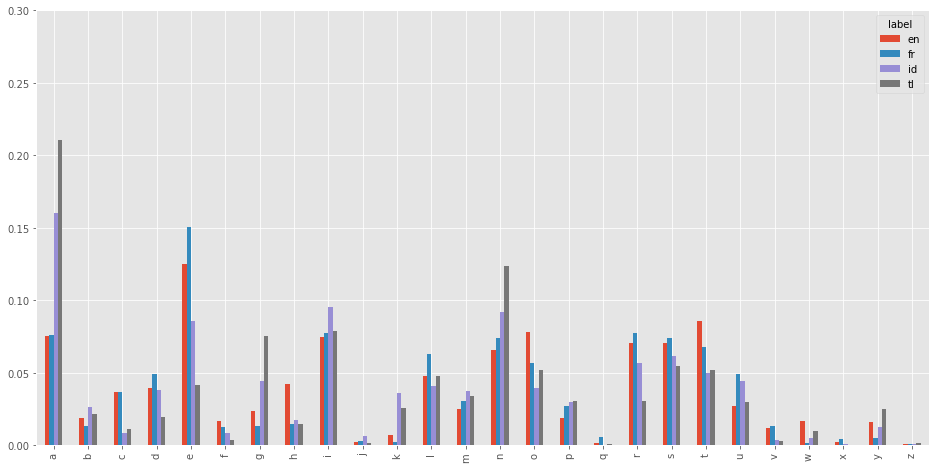

In [73]:
# 바차트 이용해서 한눈에 보기 
# 플로팅 패키지 => ggplot
# style.available
plt.style.use('ggplot')
# 플로팅, y축의 값을 특정 구간으로 제한  =>  ylim=(0,0.25)


# 한그래프에 담기 
df_pv.plot(kind='bar',figsize=(16,8), ylim=(0,0.3))

# 저장
num = 1
file_path = './img/na_per_freqs{}.png'.format(num)
print('저장경로',file_path)
plt.savefig(file_path)

저장경로 ./img/na_per_freqs2.png


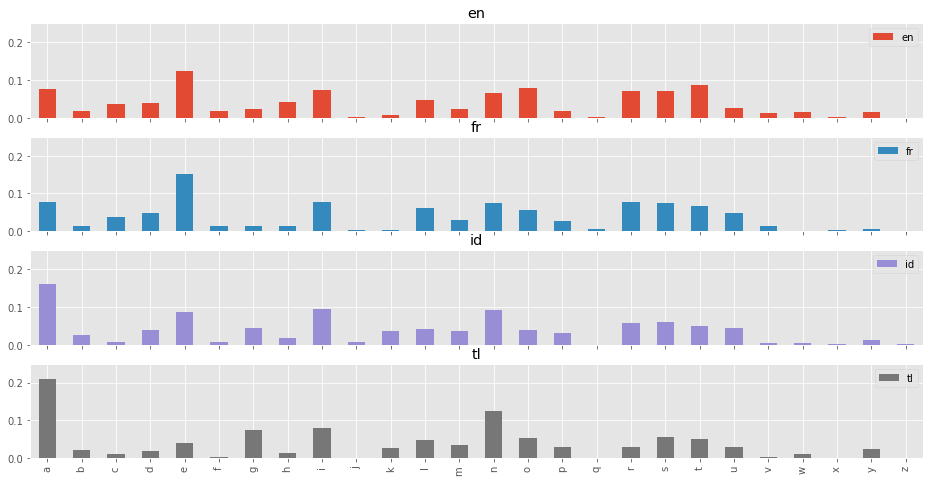

In [74]:
# 각나라별로 그래프를 그리므로서 나라별로 알파벳의 빈도수를 한눈에 확인가능
df_pv.plot(kind='bar',subplots=True,figsize=(16,8), ylim=(0,0.25))

# 저장
num = 2
file_path = './img/na_per_freqs{}.png'.format(num)
print('저장경로',file_path)
plt.savefig(file_path)

# 보이기
#plt.show()

In [75]:
# 단어(a~ z)별로 한개의 차트안에 여러국가별로 빈도를 그림
# 이미지 정장 => 각 알파벳 별로 알파벳_freqs.png => 26개가 다운로드 되어야함 
#             => a_freqs.png, b_freqs.png, .. z_freqs.png
# 한개의 차트에 여러값을 표현하여 비중의 차이점을 그린다 
# 데이터는 df_tmp를 이용하여, a만 모아서 국가별로 그리고, b만모아서그리고,..
# 한차트에 겹쳐그려서 데이터의 위치(분포)가 구분되는지, 겹치는지 확인=>히스토그램
# 추가설명
# 차트는 총 26개
# ex) a빈도를 그린다면, 한 차트에 특정국가별로 a만 그린다(국가별로색구분됨)
#     색의 겹침을 보기 위해서 투명값을 부여 alpha=0.4

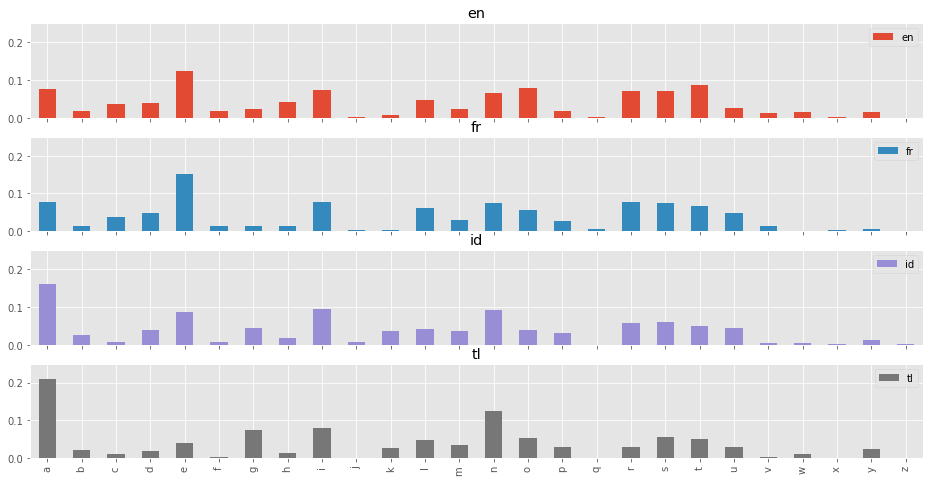

In [76]:
# 한그래프에 나오면 안되는데 .... 음 
df_pv.plot(kind='bar',subplots=True,figsize=(16,8), ylim=(0,0.25))

plt.show()

In [77]:
df_merge['label'].unique()

array(['en', 'fr', 'id', 'tl'], dtype=object)

In [78]:
# id 만 모으자 
df_merge[df_merge['label'] == 'id']

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,label
10,0.126059,0.032387,0.014449,0.034380,0.096662,0.004484,0.059791,0.013951,0.104634,0.003986,...,0.076731,0.069258,0.046836,0.042352,0.003986,0.006477,0.001495,0.009467,0.001495,id
11,0.147555,0.024698,0.009199,0.039441,0.093372,0.011089,0.033896,0.018523,0.100302,0.005292,...,0.046623,0.081401,0.050781,0.040575,0.008065,0.005040,0.001386,0.013609,0.000630,id
12,0.177360,0.023339,0.005501,0.038741,0.083651,0.012691,0.049585,0.018663,0.087148,0.007387,...,0.052061,0.047621,0.049861,0.048525,0.001572,0.004086,0.000236,0.014577,0.000236,id
13,0.169205,0.025294,0.004562,0.032405,0.069708,0.007917,0.045086,0.015029,0.097350,0.006642,...,0.050050,0.054411,0.049782,0.046629,0.002214,0.001811,0.000201,0.011741,0.000537,id
14,0.180053,0.025664,0.008246,0.046101,0.083582,0.005113,0.034121,0.020827,0.088696,0.009058,...,0.056879,0.054380,0.050208,0.043260,0.003003,0.006233,0.000308,0.012921,0.001136,id


In [79]:
# id 민 추출 했으니 알파벳 별로 추출 
df_concat[df_concat['label'] == 'en']['a']

0    0.075952
1    0.084178
2    0.071646
3    0.072210
4    0.073806
Name: a, dtype: float64

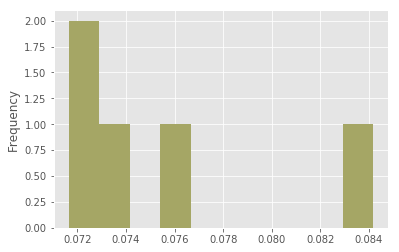

In [80]:
for word in ascii_lowercase :
#     print(word)
    for na in df_concat['label'].unique():
#         print(na)
        tmp = df_concat[df_concat['label']=='en']['a']
#         print(word, na)
        tmp.plot( kind='hist', alpha=0.4, label=na )

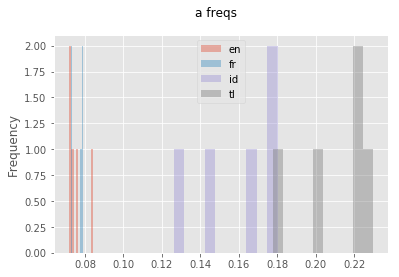

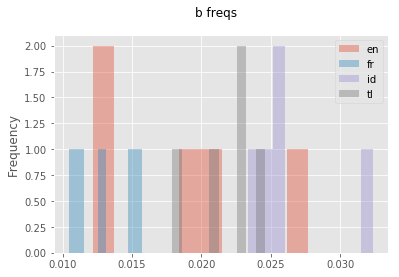

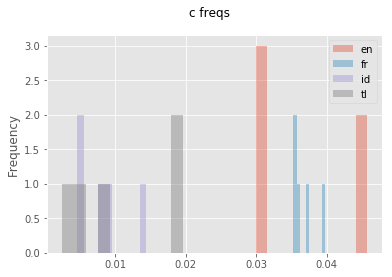

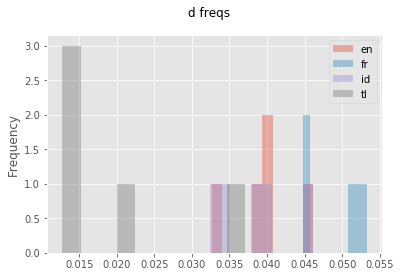

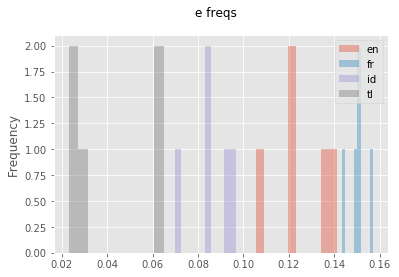

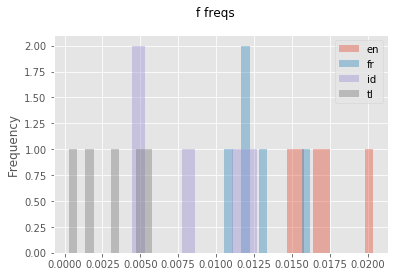

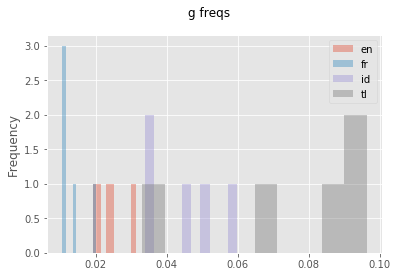

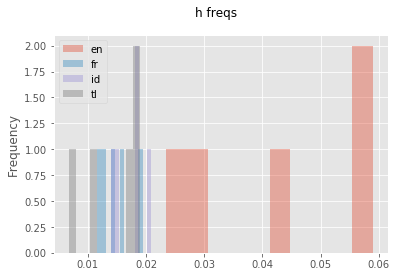

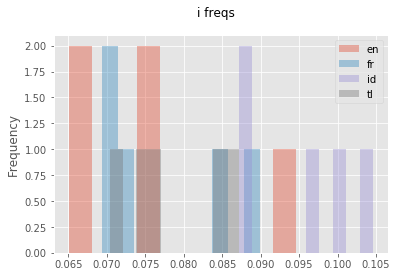

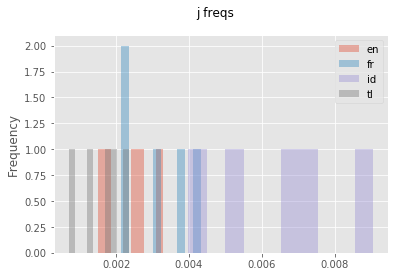

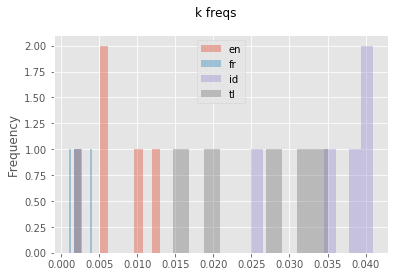

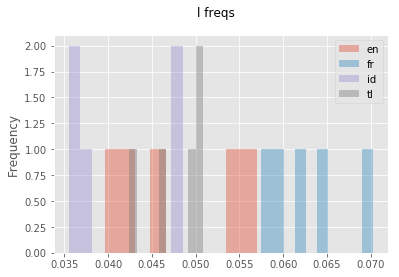

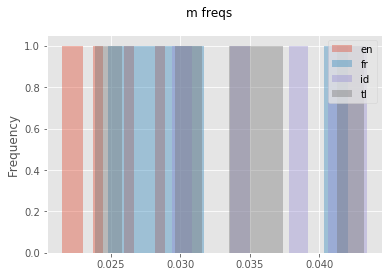

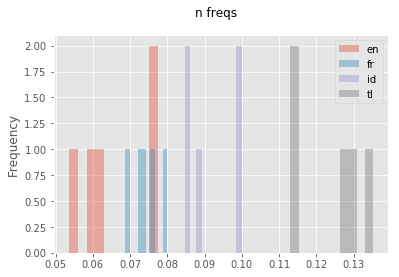

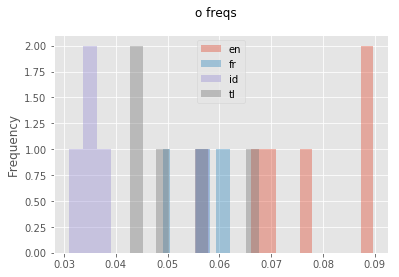

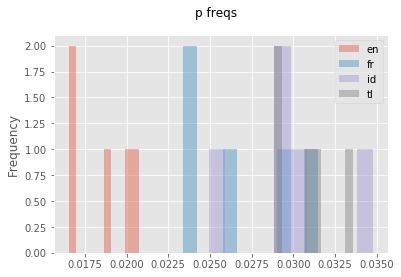

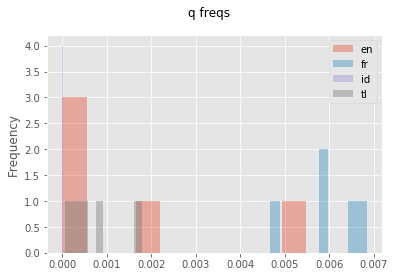

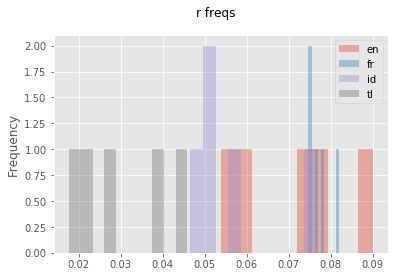

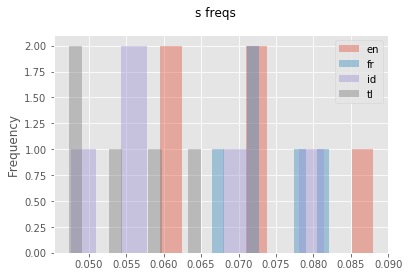

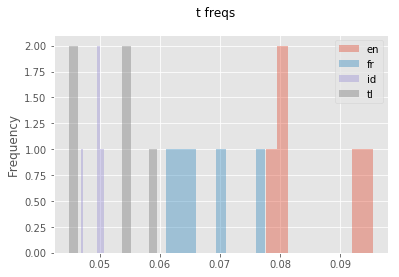

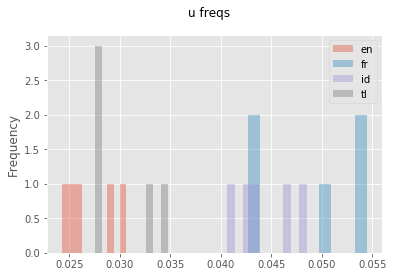

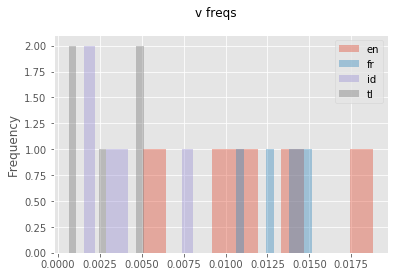

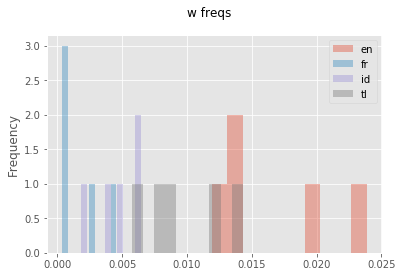

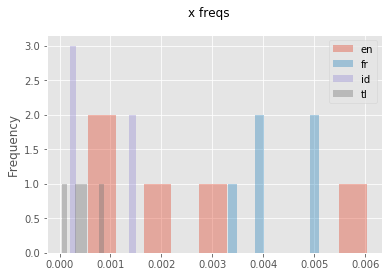

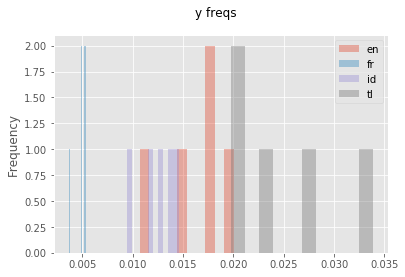

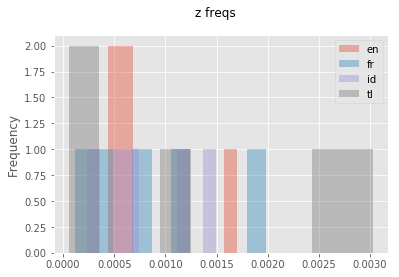

In [81]:
# a-z : 26
for word in ascii_lowercase:
#print( word )
# en, fr, id, tl : 4 
    for na in df_concat['label'].unique():
        # en이면서, a만
        # en만 모아
        tmp = df_concat[ df_concat['label'] == na ][word]
        tmp.plot( kind='hist', alpha=0.4, label=na )
        #print( word, na )
    # 차트 1개에 대한 추가분
    plt.legend()                   # 범례표기
    plt.suptitle('%s freqs' % word)# 제목
    plt.show()
#break

In [82]:
df_pv.head(2)

label,en,fr,id,tl
a,0.075558,0.076183,0.160047,0.210537
b,0.018601,0.013140,0.026276,0.021824


In [83]:
df_merge = df_concat.T
df_merge

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
a,0.0759521,0.0841779,0.0716459,0.0722097,0.0738064,0.0787381,0.0779127,0.0727165,0.0725987,0.0789474,0.126059,0.147555,0.17736,0.169205,0.180053,0.223059,0.219981,0.229718,0.177559,0.202369
b,0.01284,0.0199118,0.0121715,0.0277149,0.0203679,0.0104514,0.0149195,0.0130653,0.0157607,0.011501,0.0323866,0.0246976,0.023339,0.0252935,0.0256639,0.0245812,0.0179185,0.0210668,0.0228216,0.0227304
c,0.0457018,0.0304042,0.0456432,0.0299774,0.0310994,0.0372531,0.035749,0.0354124,0.0398362,0.0352827,0.0144494,0.00919859,0.00550077,0.00456223,0.00824622,0.00812056,0.0049892,0.00252129,0.019018,0.0195619
d,0.0461371,0.0388697,0.0326418,0.0395928,0.0396408,0.0532829,0.0448304,0.0449897,0.0511293,0.0518519,0.0343797,0.0394405,0.0387411,0.0324052,0.0461009,0.0131685,0.0139941,0.0127745,0.0217842,0.0370574
e,0.105332,0.136998,0.120055,0.121041,0.141261,0.150487,0.149735,0.150754,0.157111,0.143275,0.0966617,0.093372,0.0836509,0.0697082,0.0835822,0.0242154,0.0230598,0.0298073,0.0649205,0.0641962
f,0.0156692,0.0174079,0.0146611,0.0167798,0.0203679,0.0162221,0.0117842,0.0105232,0.0130305,0.0120858,0.0044843,0.0110887,0.0126911,0.00791681,0.0051133,0.0035116,0.0017949,0.000280143,0.00492739,0.00578592
g,0.0191513,0.0312388,0.0251729,0.0235671,0.0203679,0.0107079,0.0114959,0.0105823,0.0135269,0.020078,0.0597907,0.0338962,0.0495855,0.0450855,0.0341212,0.0963128,0.0898969,0.0914388,0.0669087,0.0330624
h,0.0437432,0.0274234,0.0235131,0.0590121,0.0569426,0.0155168,0.0126131,0.0115282,0.0143956,0.0194932,0.0139512,0.0185232,0.0186633,0.0150285,0.0208266,0.0188017,0.0168842,0.0112618,0.019018,0.00675024
i,0.0739935,0.0753547,0.0946058,0.0652338,0.065046,0.0693768,0.0720026,0.0714159,0.0856292,0.0898635,0.104634,0.100302,0.0871479,0.0973499,0.0886955,0.087168,0.085151,0.070372,0.0745159,0.0754925
j,0.00174102,0.00262311,0.00248963,0.0015083,0.00328515,0.00230828,0.0021262,0.00301508,0.00434351,0.00389864,0.00398605,0.00529234,0.00738674,0.00664207,0.00905785,0.00128027,0.000699705,0.00179292,0.0019018,0.00234192


In [84]:
len(ascii_lowercase),len(df_concat['label'])

(26, 20)

In [85]:
df_concat[df_concat['label'] == 'en']['a']

0    0.075952
1    0.084178
2    0.071646
3    0.072210
4    0.073806
Name: a, dtype: float64

In [86]:
df_concat[df_concat['label'] == 'fr']['a']

5    0.078738
6    0.077913
7    0.072717
8    0.072599
9    0.078947
Name: a, dtype: float64

In [87]:
df_concat[df_concat['label'] == 'tl']['a']

15    0.223059
16    0.219981
17    0.229718
18    0.177559
19    0.202369
Name: a, dtype: float64

In [88]:
df_concat[df_concat['label'] == 'id']['a']

10    0.126059
11    0.147555
12    0.177360
13    0.169205
14    0.180053
Name: a, dtype: float64

In [89]:
df_concat.columns

Index(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
       'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'label'],
      dtype='object')

In [90]:
alphabet = ascii_lowercase
all_nara = df_concat.label.unique()


'{}'.format(all_nara)

"['en' 'fr' 'id' 'tl']"

저장경로 ./img/a_freqs.png


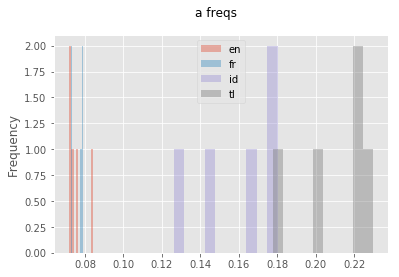

저장경로 ./img/b_freqs.png


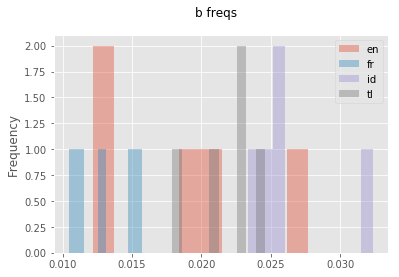

저장경로 ./img/c_freqs.png


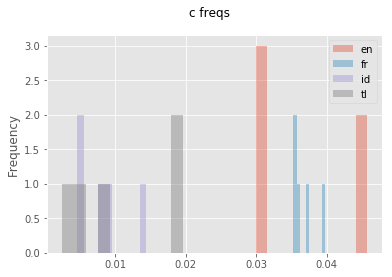

저장경로 ./img/d_freqs.png


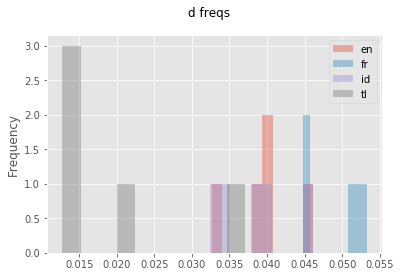

저장경로 ./img/e_freqs.png


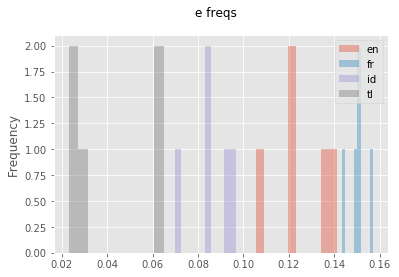

저장경로 ./img/f_freqs.png


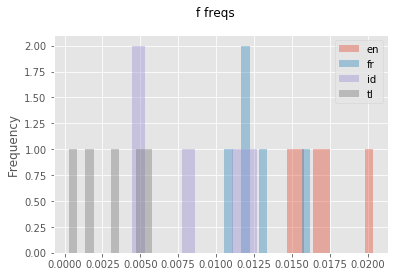

저장경로 ./img/g_freqs.png


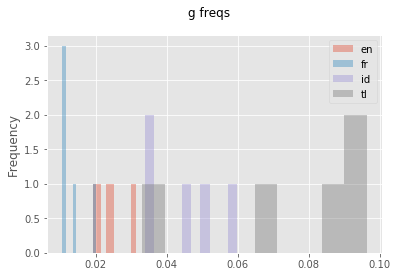

저장경로 ./img/h_freqs.png


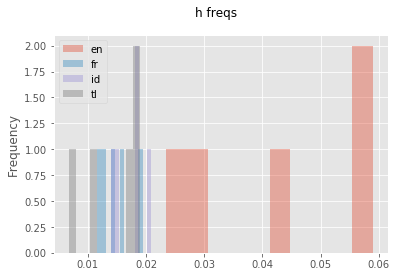

저장경로 ./img/i_freqs.png


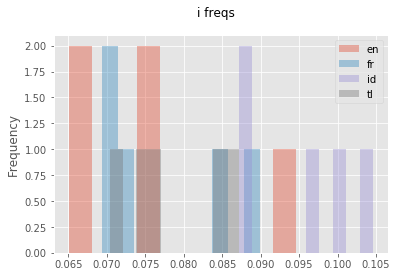

저장경로 ./img/j_freqs.png


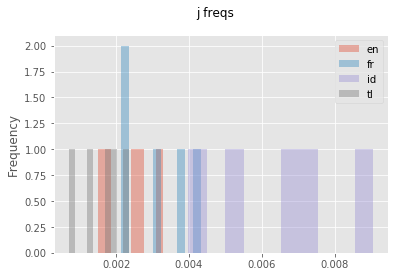

저장경로 ./img/k_freqs.png


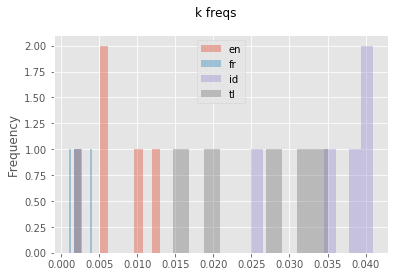

저장경로 ./img/l_freqs.png


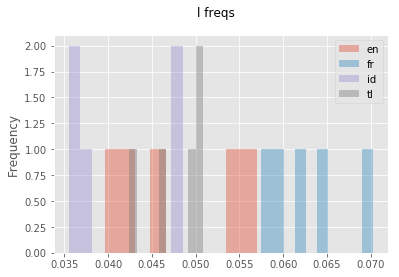

저장경로 ./img/m_freqs.png


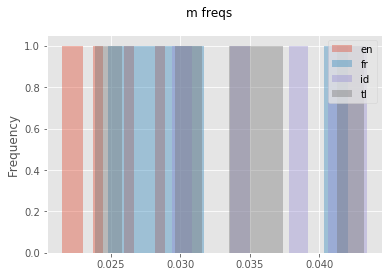

저장경로 ./img/n_freqs.png


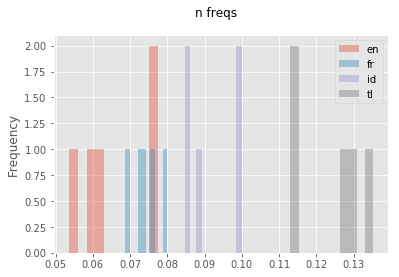

저장경로 ./img/o_freqs.png


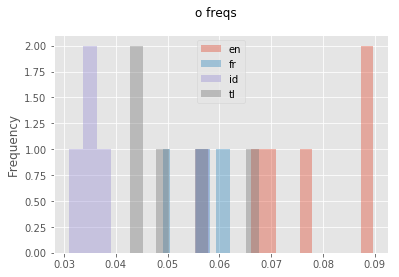

저장경로 ./img/p_freqs.png


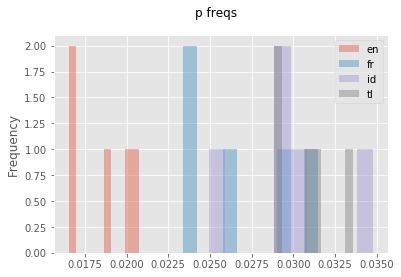

저장경로 ./img/q_freqs.png


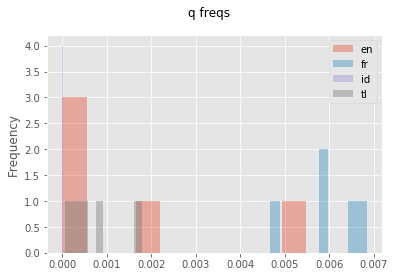

저장경로 ./img/r_freqs.png


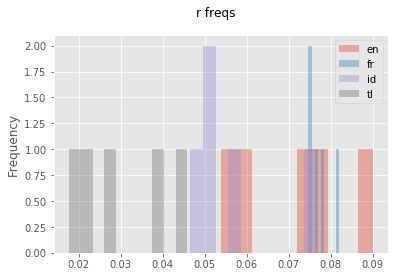

저장경로 ./img/s_freqs.png


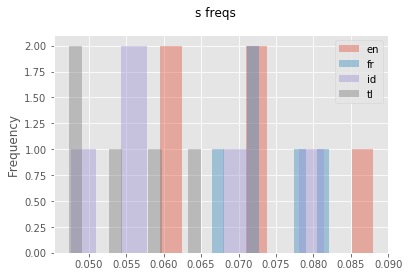

저장경로 ./img/t_freqs.png


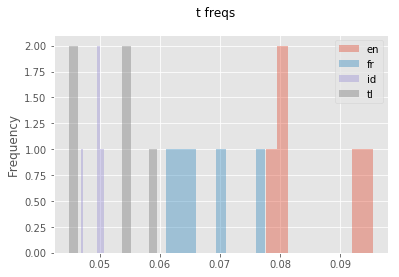

저장경로 ./img/u_freqs.png


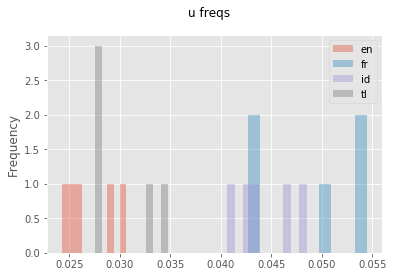

저장경로 ./img/v_freqs.png


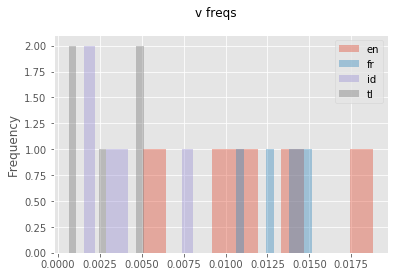

저장경로 ./img/w_freqs.png


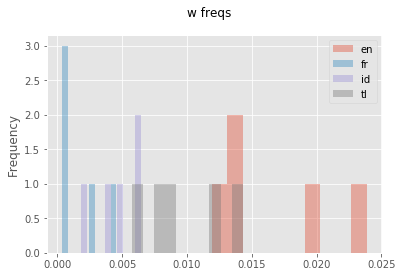

저장경로 ./img/x_freqs.png


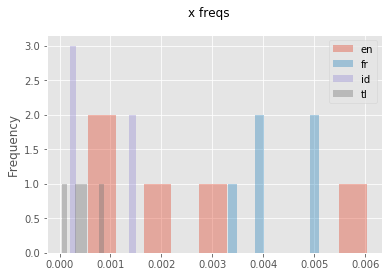

저장경로 ./img/y_freqs.png


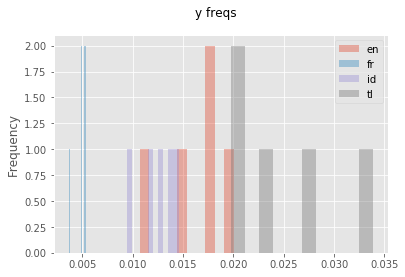

저장경로 ./img/z_freqs.png


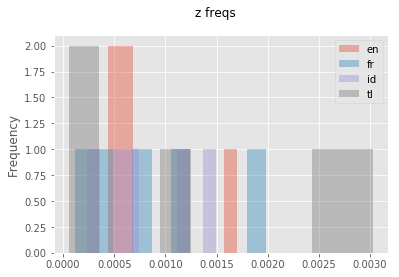

In [100]:
alphabet = ascii_lowercase
all_nara = df_concat.label.unique()
# 1. 나라부터 

# 3. 데이터 출력 

for alpa in alphabet:
#     print(alpa)
    # 2. 중복 제외 나라 픽 
    for nara in all_nara:
#         print(nara)
        # 3. 데이터 출력
        test = df_concat[ df_concat.label == '{}'.format(nara)]
#         print(test)
        test = test['{}'.format(alpa)]
        # 4. 그래프 출력해보기
        test.plot( kind='hist', alpha=0.4, label=nara )
    
    #  5. for문이 끝나기전에 사진 저장 
    # 주의 ) 들려쓰기 조심 => 포문 밖을 나가면 안됨  => 여러개 출력 불가능 
    plt.legend()                    # 각나라표기(범례)
    plt.suptitle('%s freqs' % alpa) # 제목
   
    # 저장하기 
    # 경로를 변수에 담아 저장위치와 함꼐 출력 
    file_path = './img/%s_freqs.png'% alpa
    plt.savefig(file_path)
    print('저장경로',file_path)
    plt.show()
    
#     break

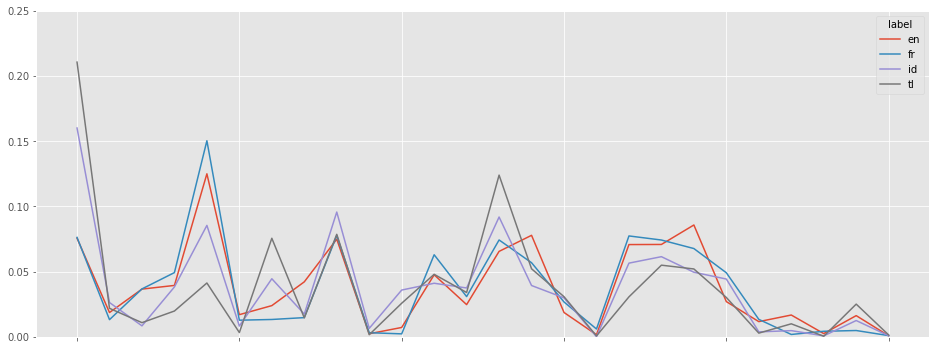

In [102]:
# 피벗으로 한 자료를 선형차드로 다시 확인 
# 빈도수를 확연하게 확인가능 
df_pv.plot( kind='line', figsize=(16,6), ylim=(0,0.25) )

# 번외 장난치기

In [ ]:
test_df_pv = df_pv.T
test_df_pv.head(2)

In [185]:
test_df_pv.columns

Index(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
       'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'],
      dtype='object')

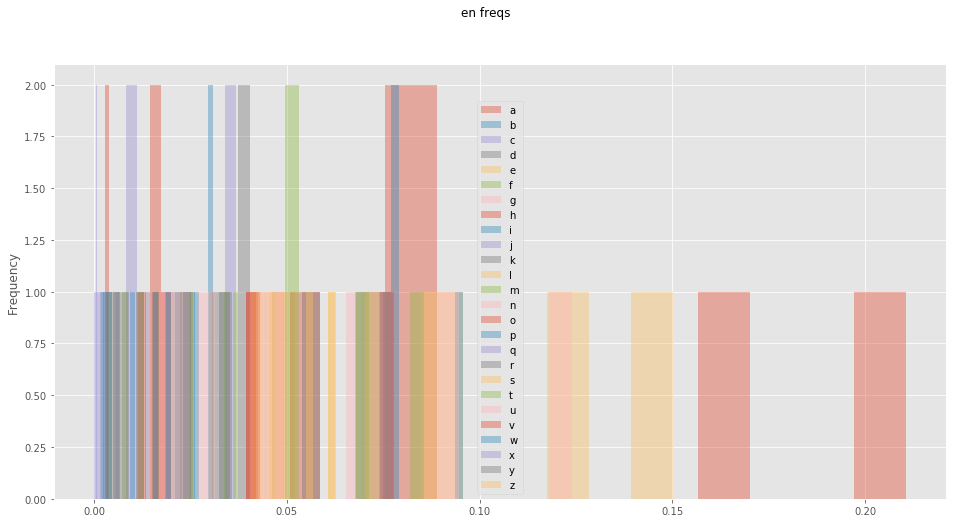

In [220]:
# 
for nara in test_df_pv.index.values:
#     print(nara)
    
    for alpa in test_df_pv.columns:
#         print(alpa)
        test_input = '%s' % alpa
#         print(test_input)
        test_grp = test_df_pv[test_input]
#         print(test_grp)
        test_grp.plot( kind='hist', alpha=0.4, label=alpa ,figsize=(16,8))
#         plot.text(alpa,)
#         print(test_grp)
    
    plt.legend()                   # 범례표기
    plt.suptitle('%s freqs' % nara)# 제목
    plt.show()    
    break


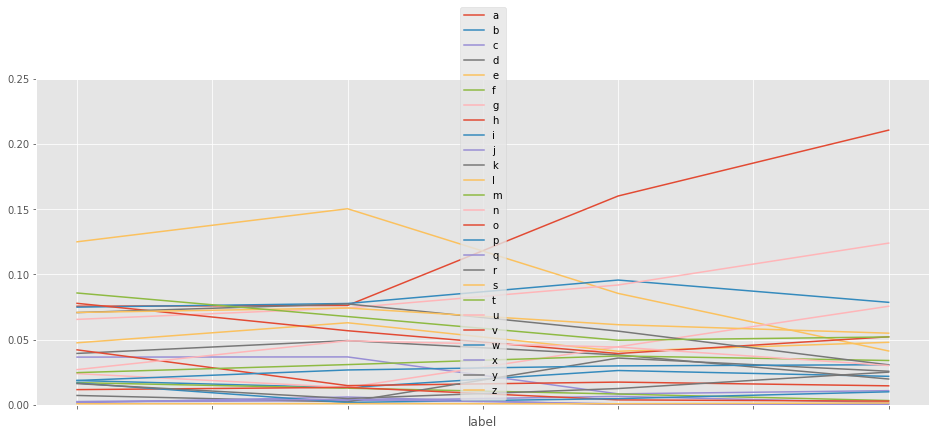

In [221]:
test_df_pv.plot( kind='line', figsize=(16,6), ylim=(0,0.25) )

---

## Step 04. 데이터 모델링 구축

## Step 05. 시스템 통합 




### 기본 Step
---

### Step_01
- 사용자가 번역에 필요한 글자를 입력 (알파벳만 사용, 영어권만 해당)  
### Step_02
- 언어감지라는 버튼을 클릭한다
### Step_03
- 언어를 읽어서 서버로 전송
### Step_04
- 서버에서 데이터를 알고리즘이 예측할수 있는 형태로 변환처리
### Step_05
- 예측
### Step_06
- 예측결과를 응답
### Step_07
- 응답 결과를 화면에 표시

---


In [ ]:
from IPython.display import Image

path = './input/6.시스템통합_최종산출물.png'
Image(path, width=500 )

# 최종 산출물  
# 웹기반 => 플라스크(간단하게 구현)
# 머신러닝(SVM,SVC)로 언어감지, 딥러닝(RNN, many to many 신경망)으로 언어 번역 

In [ ]:
# https://colab.research.google.com/drive/1j2x9zXnQ_Y4ZuJE4hwG0DhESFEpfrBkL#scrollTo=iJDRUPRyDeTV
